# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from persona_generator import generate_persona_labels

In [3]:
df_scaled = pd.read_csv('../processed/processed_customers.csv')

In [4]:
df_unscaled = pd.read_csv('../processed/processed_customers_unscaled.csv')

# BIRCH Alogrithm

In [6]:
birch_model = Birch(threshold=0.5, n_clusters=4)
birch_model.fit(df_scaled)

Birch(n_clusters=4)

In [7]:
birch_model.predict(df_scaled)

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

# Hyper-parameter Tuning

In [9]:
thresholds = np.arange(0.3, 2.0, 0.1)
n_clusters_options = [None, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results = []

for thresh in thresholds:
    for n in n_clusters_options:
        model = Birch(threshold=thresh, n_clusters=n)
        labels = model.fit_predict(df_scaled)
        
        # Silhouette requires >1 label
        if len(set(labels)) > 1:
            score = silhouette_score(df_scaled, labels)
            results.append((thresh, n, score))

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Threshold', 'n_clusters', 'Silhouette'])
best_params = results_df.loc[results_df['Silhouette'].idxmax()]

## Best Parameters for BIRCH Algorithm

In [11]:
print("Best Parameters:")
print(best_params)

Best Parameters:
Threshold     1.400000
n_clusters    2.000000
Silhouette    0.505612
Name: 111, dtype: float64


In [12]:
best_thresh = best_params['Threshold']
best_n = best_params['n_clusters']

final_birch = Birch(threshold=best_thresh, n_clusters=int(best_n))
df_unscaled['BIRCH_Cluster'] = final_birch.fit_predict(df_scaled)

In [13]:
df_unscaled.head()

,Education,Marital_Status,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Customer_Tenure,Total_Spend,Family_Size,Total_Campaigns_Accepted,Age,BIRCH_Cluster
0,Graduation,Single,58138.0,58,3,8,10,4,7,0,1,663,1617,1,0,57,0
1,Graduation,Single,46344.0,38,2,1,1,2,5,0,0,113,27,3,0,60,0
2,Graduation,Partnered,71613.0,26,1,8,2,10,4,0,0,312,776,1,0,49,0
3,Graduation,Partnered,26646.0,26,2,2,0,4,6,0,0,139,53,2,0,30,0
4,PhD,Partnered,58293.0,94,5,5,3,6,5,0,0,161,422,2,0,33,0


## Visualization of the clusters in 3D

In [15]:
df_scaled['BIRCH_Cluster'] = df_unscaled['BIRCH_Cluster']

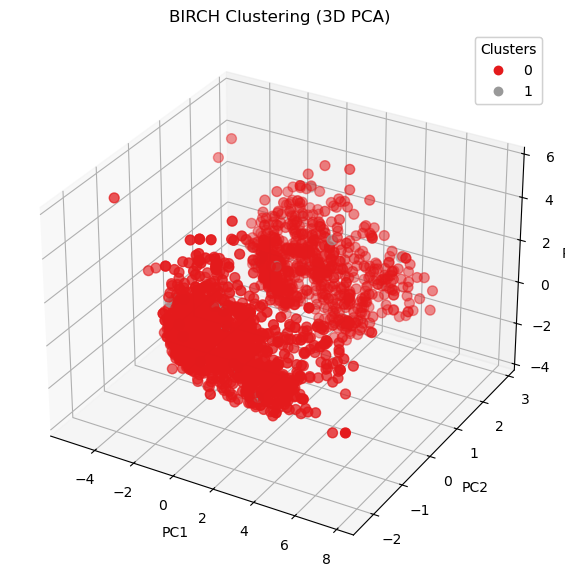

In [16]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled.drop('BIRCH_Cluster', axis=1))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                     c=df_scaled['BIRCH_Cluster'], cmap='Set1', s=50)
ax.set_title("BIRCH Clustering (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.show()

## Cluster Summarization

In [18]:
cluster_summary = df_unscaled.groupby('BIRCH_Cluster').mean(numeric_only=True)
cluster_summary

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Customer_Tenure,Total_Spend,Family_Size,Total_Campaigns_Accepted,Age
BIRCH_Cluster,,,,,,,,,,,,,,
0,52314.269248,48.974032,2.323462,4.089749,2.676993,5.806378,5.314351,0.0,0.150342,352.862415,609.282005,1.944875,0.299772,45.143964
1,45242.285714,53.047619,2.333333,3.619048,2.047619,5.238095,5.809524,1.0,0.142857,422.380952,376.428571,2.190476,0.142857,48.904762


In [19]:
cluster_std = df_unscaled.groupby('BIRCH_Cluster').std(numeric_only=True)
cluster_std

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Customer_Tenure,Total_Spend,Family_Size,Total_Campaigns_Accepted,Age
BIRCH_Cluster,,,,,,,,,,,,,,
0,25217.184933,28.956082,1.928099,2.739638,2.927566,3.247796,2.426034,0.0,0.357487,202.465909,603.947069,0.748237,0.680752,11.870398
1,19223.158027,28.522756,1.425950,2.906479,2.836833,3.590331,2.358369,0.0,0.358569,191.349804,432.101327,0.813575,0.478091,20.916273


In [20]:
for cluster in sorted(df_unscaled['BIRCH_Cluster'].unique()):
    print(f"Cluster {cluster} Summary:")
    print(cluster_summary.loc[cluster])
    print("\n---\n")

Cluster 0 Summary:
Income                      52314.269248
Recency                        48.974032
NumDealsPurchases               2.323462
NumWebPurchases                 4.089749
NumCatalogPurchases             2.676993
NumStorePurchases               5.806378
NumWebVisitsMonth               5.314351
Complain                        0.000000
Response                        0.150342
Customer_Tenure               352.862415
Total_Spend                   609.282005
Family_Size                     1.944875
Total_Campaigns_Accepted        0.299772
Age                            45.143964
Name: 0, dtype: float64

---

Cluster 1 Summary:
Income                      45242.285714
Recency                        53.047619
NumDealsPurchases               2.333333
NumWebPurchases                 3.619048
NumCatalogPurchases             2.047619
NumStorePurchases               5.238095
NumWebVisitsMonth               5.809524
Complain                        1.000000
Response                      

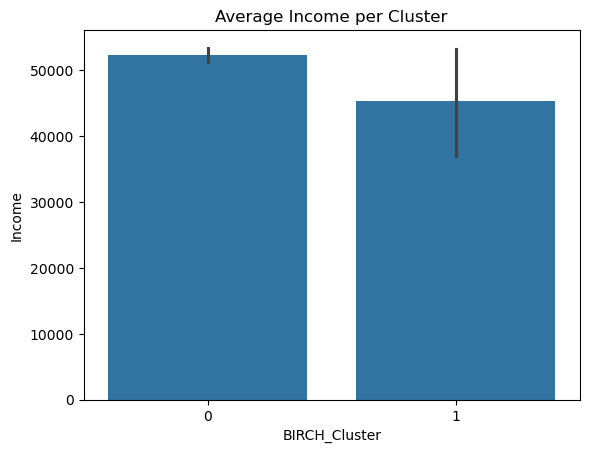

In [21]:
sns.barplot(x='BIRCH_Cluster', y='Income', data=df_unscaled)
plt.title('Average Income per Cluster')
plt.show()

In [22]:
from persona_generator import generate_persona_labels
labels = generate_persona_labels(cluster_summary)

In [23]:
for cluster, label in labels.items():
    print(f"Cluster {cluster}: {label}")

Cluster 0: Middle-Income, Moderate Spender, No Complaints, Middle-Aged, Small Households
Cluster 1: Middle-Income, Moderate Spender, Complainers, Middle-Aged, Small Households


It seems BIRCH algorithm could not seperate the data points to be able to draw clear distinctions between the clusters. We'll compare BIRCH later with the other algorithms.

In [25]:
df_unscaled.to_csv('../processed/birch.csv', index = False)

In [26]:
from persona_generator import generate_persona_labels
labels = generate_persona_labels(cluster_summary)
for cluster, label in labels.items():
    print(f"Cluster {cluster}: {label}")

Cluster 0: Middle-Income, Moderate Spender, No Complaints, Middle-Aged, Small Households
Cluster 1: Middle-Income, Moderate Spender, Complainers, Middle-Aged, Small Households
